<a href="https://colab.research.google.com/github/Grey-Xu-Yang/ESG_Finance_Putian/blob/main/hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW3

In this homework, we will
- Build a neural network based part of speech (POS) tagger [35 points].
- Run the model on a GPU at Google Colab [10].
- Extend the model to use pretrained embeddings [15].
- Extend the model in some manner of your own choosing [30].

There are a total of 8 tasks.

Acknowledgements: Part of this homework were adapted from work done by
[Ben Trevett](https://github.com/bentrevett) and
[Kevin Gimpel](https://home.ttic.edu/~kgimpel/).

### Installing libraries

You don't need to install any additional libraries other than those in HW2.  When working with [Google Colab](https://colab.research.google.com/), however, in a new runtime, you'll have to install the `portalocker`:

`!pip install portalocker`

Further, in Colab, you may view the status of the runtime GPU will the command:

`!nvidia-smi`

In [ ]:
!pip install portalocker
!nvidia-smi

Wed Jan 31 20:59:26 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from collections import Counter
import random

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext


In [ ]:
# Check your library versions.  They should be
# torch 2.0.0 and torchtext 0.15.1.
print(f"torch {torch.__version__}, torchtext {torchtext.__version__}")

torch 2.1.0+cu121, torchtext 0.16.0+cpu


In [ ]:
SEED = 30255 # Specify a seed for reproducability

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### Using GPUs

We want our code to run on a CPU or on a [GPU](https://en.wikipedia.org/wiki/Graphics_processing_unit) when available, as on Google Colab.  The code will likely run at least five times as fast on a GPU. PyTorch connects with a GPU via the system interface [CUDA](https://en.wikipedia.org/wiki/CUDA).

The following tells us whether CUDA/GPU is available or not.  The changes you have to make so that your code can use a GPU when available are surprisingly small. All such changes have already been made in the provided code below. They are:
- the data loader needs to place the input to the model appropriately using `to(device).`
- similarly, the model object itself needs to be placed appropriately using `to(device).`


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"torch.device: {device}")

torch.device: cuda


### UDPOS Dataset

We'll work with the [`UDPOS`](https://pytorch.org/text/stable/datasets.html#udpos) dataset included with torchtext.  It contains about 12,500 sentences and the POS tags for the each word.  There are, in fact, two sets of tags, based on two different POS tagging standards: [Universal Dependency](https://universaldependencies.org/u/pos/) (UD) and [Penn Treebank](https://www.sketchengine.eu/penn-treebank-tagset/) (PTB). It has additionally about 2000 sentences in the validation and test sets.  The words and corresonding tags are organized into lists.

In [ ]:
train_iter = torchtext.datasets.UDPOS(split = 'train')

for i, example in enumerate(train_iter):
    print(f'The sentence for Example {i} ---')
    print(example[0])
    print(f'The UD tags for Example {i} ---')
    print(example[1])
    print(f'The PTB tags for Example {i} ---')
    print(example[2])
    print()
    if i == 2: break

The sentence for Example 0 ---
['Al', '-', 'Zaman', ':', 'American', 'forces', 'killed', 'Shaikh', 'Abdullah', 'al', '-', 'Ani', ',', 'the', 'preacher', 'at', 'the', 'mosque', 'in', 'the', 'town', 'of', 'Qaim', ',', 'near', 'the', 'Syrian', 'border', '.']
The UD tags for Example 0 ---
['PROPN', 'PUNCT', 'PROPN', 'PUNCT', 'ADJ', 'NOUN', 'VERB', 'PROPN', 'PROPN', 'PROPN', 'PUNCT', 'PROPN', 'PUNCT', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'PROPN', 'PUNCT', 'ADP', 'DET', 'ADJ', 'NOUN', 'PUNCT']
The PTB tags for Example 0 ---
['NNP', 'HYPH', 'NNP', ':', 'JJ', 'NNS', 'VBD', 'NNP', 'NNP', 'NNP', 'HYPH', 'NNP', ',', 'DT', 'NN', 'IN', 'DT', 'NN', 'IN', 'DT', 'NN', 'IN', 'NNP', ',', 'IN', 'DT', 'JJ', 'NN', '.']

The sentence for Example 1 ---
['[', 'This', 'killing', 'of', 'a', 'respected', 'cleric', 'will', 'be', 'causing', 'us', 'trouble', 'for', 'years', 'to', 'come', '.', ']']
The UD tags for Example 1 ---
['PUNCT', 'DET', 'NOUN', 'ADP', 'DET', 'ADJ', 'NOUN', 'AUX',

### Preprocessing

In our neural network-based model we can only accept fixed sized inputs.  Each input corresponds to a subsequence, consisting of a  center word and a number $w$ of words before and after, and the label is the POS tag for the center word. We often refer to the subsequence as a window of size $(2w + 1)$.

So given a sentence, say, "This killing of a respected cleric.' with, tags, say 'DET', 'NOUN', 'ADP', 'DET', 'ADJ', 'NOUN', 'PUNCT' (the last tag is for the period at the end of the sentence), some of our input examples for the model are the following (for $w = 1$):
- "This killing of", 'NOUN'
- "killing of a", 'ADP'
- "respected cleric.", 'NOUN'.

But the above scheme would imply that, when $w = 1$, the tags of the first and last words for any sentence would never be part of an example.  To avoid that, we add dummy '\<s>' and '\</s>' words, and corresponding tags, to the beginning and end of each sentence.  We need to add as many dummy words as $w$.  So if $w = 2$, we first convert the above sentence and its tags to
- "\<s> \<s> This killing of a respected cleric. \</s> \</s>'
- 'STAG', 'STAG','DET', 'NOUN', 'ADP', 'DET', 'ADJ', 'NOUN', 'PUNCT', 'ETAG', 'ETAG'.

**Task 1** [5 points]: Most of the code for preprocessing is given below.  But some parts are missing.  Complete the code.  (The code makes advanced use of the [zip](https://docs.python.org/3.3/library/functions.html#zip) function.  Please learn this idiom for working with tuples and iterators.)

In [ ]:
W = 1
WINDOW_SIZE = (2 * W + 1)

SENT_START_WORD = '<s>'
SENT_END_WORD = '</s>'
SENT_START_TAG = '<STAG>'
SENT_END_TAG = '<ETAG>'


def add_sent_start_end(data_iter, w):
    for (words, ud_tags, ptb_tags) in data_iter:
        new_words = [SENT_START_WORD] * w + words + [SENT_END_WORD] * w
        new_ud_tags = [SENT_START_TAG] * w + ud_tags + [SENT_END_TAG] * w
        ## MISSING PART: ADD YOUR CODE BELOW
        new_ptb_tags = [SENT_START_TAG] * w + ptb_tags + [SENT_END_TAG] * w

        ## ADD YOUR CODE ABOVE
        yield(new_words, new_ud_tags, new_ptb_tags)

def create_windows(data_iter, w):
    window_size = 2*w + 1
    for (words, ud_tags, ptb_tags) in data_iter:
        words_zip = zip(*[words[i:] for i in range(window_size)])
        ud_zip = zip(*[ud_tags[i:] for i in range(window_size)])
        ## MISSING PART: ADD YOUR CODE BELOW
        ptb_zip = zip(*[ptb_tags[i:] for i in range(window_size)])

        ## ADD YOUR CODE ABOVE
        for word_sseq, ud_sseq, ptb_sseq in zip(
                words_zip, ud_zip, ptb_zip):
            yield(word_sseq, ud_sseq, ptb_sseq)

def preprocess_data_seq(data_iter, w):
    ## MISSING PART: ADD YOUR CODE BELOW
    added_sent_data = add_sent_start_end(data_iter, w)
    return create_windows(added_sent_data, w)


def test_preprocess_data_seq():

    # WARNING: The following test assumes a particular default
    # sequence of examples in the PyTorch UDPOS dataset. If you
    # suspect the sequence is different for your dataset, please
    # adapt the test.

    train_iter_0 = torchtext.datasets.UDPOS(split = 'train')
    train_iter_demo = preprocess_data_seq(train_iter_0, 1)
    ex0 = (('<s>', 'Al', '-'),
           ('<STAG>', 'PROPN', 'PUNCT'),
           ('<STAG>', 'NNP', 'HYPH'))
    ex1 = (('Al', '-', 'Zaman'),
           ('PROPN', 'PUNCT', 'PROPN'),
           ('NNP', 'HYPH', 'NNP'))
    ex2 = (('-', 'Zaman', ':'),
           ('PUNCT', 'PROPN', 'PUNCT'),
           ('HYPH', 'NNP', ':'))
    assert ex0 == next(train_iter_demo)
    assert ex1 == next(train_iter_demo)
    assert ex2 == next(train_iter_demo)
    print('Test passed.')


test_preprocess_data_seq()

Test passed.


### Create vocabularies for words and tags

Since the number of tags is reasonably large, we use the `Vocab` class to create objects `vocab_words`, `vocab_ud`, and `vocab_ptb` for both words and the two sets of tags from the training set.

In [ ]:
# It is important to recreate the training set afresh
# each time they are used, since they are Python iterators, and
# once used, cannot be reused.  One could, however, cast them into
# a list, which would store them permanently.

train_iter_0 = torchtext.datasets.UDPOS(split = 'train')
train_iter_vocab = preprocess_data_seq(train_iter_0, 1)

counter_words = Counter()
counter_ud = Counter()
counter_ptb = Counter()
for (text, pos_ud, pos_ptb) in train_iter_vocab:
    counter_words.update(text)
    counter_ud.update(pos_ud)
    counter_ptb.update(pos_ptb)


vocab_words = torchtext.vocab.vocab(counter_words,  specials = ['<unk>'],
                    special_first = True)
vocab_words.set_default_index(0)
vocab_ud = torchtext.vocab.vocab(counter_ud)
vocab_ptb = torchtext.vocab.vocab(counter_ptb)

print(f"{len(vocab_words)} words, {len(vocab_ud)} ud pos classes, {len(vocab_ptb)} ptb pos classes")

19675 words, 19 ud pos classes, 52 ptb pos classes


Observe that we set a special word for vocab_words, but none for vocab_ud or vocab_ptb.  Why is that? (You don't have to submit an answer.)

### Collate function for customized data loader

**Task 2** [10]: Write a collate function that takes a batch of examples, and for a given window width and tag type, returns the following
- a tensor corresponding to the index of the tag for the center word in each example of the batch. Recall, each example is a window with a width of $(2w + 1)$ words.
- a tensor corresponding to the index of each of the words in the example, according the to vocabulary for words.

Note: The collate function is called by the data loader with the batch of examples from the data set.  So any additional parameters to the function should have default values.

From this task onwards we'll only work with the UD tags.

In [ ]:
from torch.utils.data import DataLoader

TAG = 'ud'

def collate_fn(batch, w=W, tag=TAG):
    word_indices = []
    labels = []

    for words, utags, ptags in batch:
        # Choose the correct tag list based on the tag type
        input_tags = utags if tag == 'ud' else ptags

        # Convert words to indices using vocab_words
        word_idx = [vocab_words[word] for word in words]

        # Convert the center tag to index using vocab_ud or vocab_ptb
        center_tag = input_tags[w]
        label_idx = vocab_ud[center_tag] if tag == 'ud' else vocab_ptb[center_tag]

        word_indices.append(word_idx)
        labels.append(label_idx)

    # Convert lists to tensors
    word_idxs_tensor = torch.tensor(word_indices)
    labels_tensor = torch.tensor(labels)

    return labels_tensor.to(device), word_idxs_tensor.to(device)


def test_collate():

    position = [5, 6, 1, 4]
    examples = []
    for perm in ['03022', '33210', '33211', '11101']:
        words = []
        utags = []
        ptags = []
        for ind in perm:
            ind = int(ind)
            words.append(vocab_words.lookup_token(position[ind]))
            utags.append(vocab_ud.lookup_token(position[ind]+1))
            ptags.append(vocab_ptb.lookup_token(position[ind]))

        examples.append((words, utags, ptags))

    lt =  torch.tensor([6, 2, 2, 7]).to(device)
    wt = torch.tensor([
        [5, 4, 5, 1, 1],
        [4, 4, 1, 6, 5],
        [4, 4, 1, 6, 6],
        [6, 6, 6, 5, 6]]).to(device)
    rlt, rwt = collate_fn(examples, w = 2)
    assert torch.equal(lt, rlt)
    assert torch.equal(wt, rwt)
    print('test_collate passed')

test_collate()


test_collate passed


### Writing the class for the neural network model

**Task 3** [15]: Write a class that implements the following neural network for input $(w_1, w_2, w_3)$ and label $y$ corresponding to tag of $w_2$.
$$
\begin{eqnarray*}
x &=& [E_{[w_1]}, E_{[w_2]}, E_{[w_3]}] \\
h &=& \text{tanh}(x W^1 + b^1)\\
\tilde{y} & = & hW^2 + b^2\\
\hat{y} & = & \text{softmax}(y)\\
\end{eqnarray*}
$$
The model returns $\ln \hat{y}$, and expects the training loop to use `nn.NLLLoss()` to compute the cross entropy loss, given $y$. Assume the embedding has vectors of size $300$, and $h$ is a vector of size $128$.  Please read the documentation for `nn.Embedding(),` `nn.Linear(),`, and `nn.Tanh()` to learn how to use them.

*Hint:* Unlike HW2, here the input (for each example in a batch) consist of $(2w+1)$ numbers corresponding to the indices of the words in the window. These are converted to $(2w+1)$ vectors when they are passed to the embedding layer. They have to be concatenated into a single vector of length $(2w+1) \times 300$ before they are sent to the first linear layer ($W^1$).  Use `reshape()` or `view()` in the `forward()` function below to achieve this.


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class NNPOSTagger(nn.Module):
    def __init__(self,
                 window_size,
                 vocab_size,
                 embedding_dim,
                 hidden_dim,
                 output_dim,
                 nonlinearity,
                 # These are used for later tasks
                 use_glove = False,
                 freeze_glove = False):
        super(NNPOSTagger, self).__init__()

        # Define an embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # Define the first linear layer
        self.linear1 = nn.Linear(window_size * embedding_dim, hidden_dim)

        # Define the second linear layer
        self.linear2 = nn.Linear(hidden_dim, output_dim)

        # Nonlinearity (tanh)
        self.nonlinearity = nonlinearity

    def forward(self, word_idxs_batch):

        # Embedding layer
        embeddings = self.embedding(word_idxs_batch)

        # Reshape embeddings to concatenate
        concatenated = embeddings.view(embeddings.shape[0], -1)

        # First Linear layer and Tanh activation
        hidden = self.linear1(concatenated)
        tanh_output = torch.tanh(hidden)

        # Second Linear layer
        output = self.linear2(tanh_output)

        # Log Softmax (use NLLLoss during training)
        log_softmax_output = F.log_softmax(output, dim=1)

        return log_softmax_output

#### Instantiating the model

PyTorch uses `to(device)` to specify whether the model is to be used with a CPU or with a GPU/CUDA.

In [ ]:
model = NNPOSTagger(window_size = WINDOW_SIZE,
                    vocab_size = len(vocab_words),
                     embedding_dim = 300,
                     hidden_dim = 128,
                     output_dim = len(vocab_ud),
                     nonlinearity = nn.Tanh(),
                     use_glove = False,
                     freeze_glove = False).to(device)

### Training an epoch

**Task 4** [5]: Write a function to train one epoch of the dataset. This is similar to the code in HW2.

In [ ]:
loss_function = torch.nn.NLLLoss()

def train_an_epoch(dataloader, optimizer, mod):
    mod = mod
    mod.train() # Sets the module in training mode.
    log_interval = 500
    total_loss = 0

    for idx, (label, text) in enumerate(dataloader):
        optimizer.zero_grad()  # Clears old gradients from the last step
        log_probs = mod(text)  # Passes the batch of text through the model
        loss = loss_function(log_probs, label)  # Computes the loss
        loss.backward()  # Computes the gradients
        optimizer.step()  # Updates the weights

        total_loss += loss.item()

    return total_loss

### Computing the accuracy

The function is given below.

In [ ]:
def get_accuracy(dataloader, mod):
    mod = mod
    mod.eval()
    with torch.no_grad():
        total_acc, total_count = 0, 0
        for idx, (label, word_idxs) in enumerate(dataloader):
            log_probs = mod(word_idxs)
            total_acc += (log_probs.argmax(1) == label).sum().item()
            total_count += label.size(0)

    return total_acc/total_count

### Creating the data loaders

In [ ]:
BATCH_SIZE = 64 # batch size for training

train_0, valid_0, test_0 = train_data_0 = torchtext.datasets.UDPOS(
    split = ('train', 'valid', 'test'))
train_data = list(preprocess_data_seq(train_0, W))
valid_data = list(preprocess_data_seq(valid_0, W))
test_data = list(preprocess_data_seq(test_0, W))

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE,
                              shuffle=True,
                              collate_fn=collate_fn)
valid_dataloader = DataLoader(valid_data, batch_size=BATCH_SIZE,
                              shuffle=False,
                              collate_fn=collate_fn)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE,
                             shuffle=False,
                             collate_fn=collate_fn)

### Training

Epoch: 1, time taken: 14.0s, validation accuracy: 0.771.
Epoch: 2, time taken: 11.5s, validation accuracy: 0.805.
Epoch: 3, time taken: 11.5s, validation accuracy: 0.824.


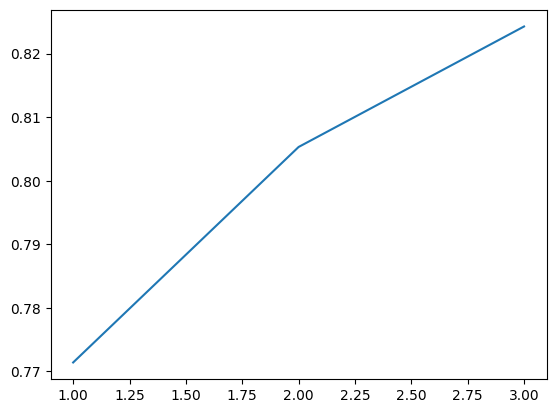

In [ ]:
import time
import matplotlib.pyplot as plt
%matplotlib inline

EPOCHS = 3 # epoch
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

accuracies=[]
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train_an_epoch(train_dataloader, optimizer, model)
    accuracy = get_accuracy(valid_dataloader, model)
    accuracies.append(accuracy)
    time_taken = time.time() - epoch_start_time
    print(f'Epoch: {epoch}, time taken: {time_taken:.1f}s, validation accuracy: {accuracy:.3f}.')

plt.plot(range(1, EPOCHS+1), accuracies)

### Running on Google Colab

Google Colab provides GPUs on which we can run Jupyter notebooks. These are for free as long as the job takes less than, say, 4 hours. Our job will take much less.

Please create an account on Google if you don't have one.  Please read a tutorial on using Colab (such as [this](https://colab.research.google.com/notebooks/intro.ipynb)).  Upload your notebook on Colab. **Change the runtime type to GPU.** Make any changes required to get your code to run on Colab. (Normally there should  be no change required.)

For all following tasks that required running your code for several epochs, we recommend developing your code locally, but finally running it on Colab to get the results.

**Task 5** [10]: Run the model for a sufficient number of epochs (not more than 30) such that the model shows overfitting, if at all, and submit a pdf of the plot of accuracy against number of epochs. Determine the optimal number of epochs to train for. Write code to estimate the accuracy of your model (using the test set) corresponding to this optimal number of epocs and report this estimated accuracy.

Text(0.5, 1.0, 'Validation Accuracy Curve')

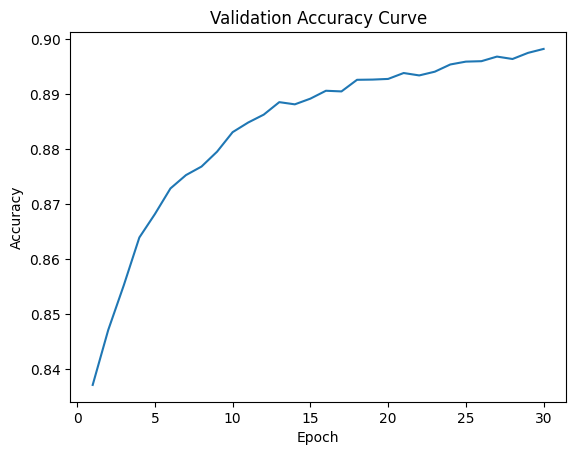

In [ ]:
%matplotlib inline

EPOCHS = 30 # epoch
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

accuracies=[]
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train_an_epoch(train_dataloader, optimizer, model)
    accuracy = get_accuracy(valid_dataloader, model)
    accuracies.append(accuracy)

plt.plot(range(1, EPOCHS+1), accuracies)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Validation Accuracy Curve")

### Initializing with pre-trained embeddings

In the above model, the embedding matrix is initialized to either zero or random vectors, but trained along with the rest of the parameters. It may help to initialize the embedding matrix from GloVe vector embeddings. You may then choose to freeze the embedding matrix (i.e., not update the vectors during training) or train them to adapt to the POS examples. (For further details you may optionally read Section 10.1--3 from the Goldberg textbook.)

#### Caching for GloVe

If you have already downloaded GloVe in a directory, you may reuse it.  Please change the following if so.

In [ ]:
import os

#glove = torchtext.vocab.GloVe('6B')

# If, instead, you would like to specify a cache directory,
# uncomment the two lines below

cache_dir: str = "/Users/greyxu/Desktop/mlpp23/.vector_cache"
glove = torchtext.vocab.GloVe('6B', cache=cache_dir)

print(f"Glove embedding files:\
    {os.listdir(cache_dir)} in {os.path.abspath(cache_dir)}")

/Users/greyxu/Desktop/mlpp23/.vector_cache/glove.6B.zip: 862MB [02:39, 5.42MB/s]                           
100%|█████████▉| 399999/400000 [00:51<00:00, 7725.66it/s]


Glove embedding files:    ['glove.6B.50d.txt', 'glove.6B.100d.txt', 'glove.6B.zip', 'glove.6B.300d.txt.pt', 'glove.6B.200d.txt', 'glove.6B.300d.txt'] in /Users/greyxu/Desktop/mlpp23/.vector_cache


The following code snippet creates a embedding matrix that has a vector corresponding to each of our `vocab_words` created from the training set.

In [ ]:
glove_vectors = glove.get_vecs_by_tokens(vocab_words.get_itos())
print(f"Glove vectors tensor shape: {glove_vectors.shape}")

Glove vectors tensor shape: torch.Size([19675, 300])


**Task 6** [10]: Rewrite/extend the code for the module to initialize the embedding layer with `glove_vectors` created above.  Please read the documentation for the function [`nn.Embedding.from_pretrained()`](https://pytorch.org/docs/master/generated/torch.nn.Embedding.html#torch.nn.Embedding.from_pretrained) to understand how this is done. Submit corresponding plot and report on the performance when the embedding is frozen.

**Task 7** [5]: Submit corresponding plot and report on the performance when the embedding is not frozen.

In [ ]:
class NNPOSTagger_Glove(nn.Module):
    def __init__(self,
                 window_size,
                 vocab_size,
                 embedding_dim,
                 hidden_dim,
                 output_dim,
                 nonlinearity,
                 use_glove=False,
                 freeze_glove=False):
        super(NNPOSTagger_Glove, self).__init__()

        # Check if GloVe vectors are to be used
        if use_glove:
            # glove_vectors is a pre-loaded tensor of GloVe embeddings
            self.embedding = nn.Embedding.from_pretrained(glove_vectors, freeze=freeze_glove)
        else:
            # Define a trainable embedding layer if GloVe is not used
            self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # Define the first linear layer
        self.linear1 = nn.Linear(window_size * embedding_dim, hidden_dim)

        # Define the second linear layer
        self.linear2 = nn.Linear(hidden_dim, output_dim)

        # Nonlinearity (tanh)
        self.nonlinearity = nonlinearity

    def forward(self, word_idxs_batch):
        # Embedding layer
        embeddings = self.embedding(word_idxs_batch)

        # Reshape embeddings to concatenate
        concatenated = embeddings.view(embeddings.shape[0], -1)

        # First Linear layer and Tanh activation
        hidden = self.linear1(concatenated)
        tanh_output = torch.tanh(hidden)

        # Second Linear layer
        output = self.linear2(tanh_output)

        # Log Softmax (use NLLLoss during training)
        log_softmax_output = F.log_softmax(output, dim=1)

        return log_softmax_output

Text(0.5, 1.0, 'Validation Accuracy Curve using Glove')

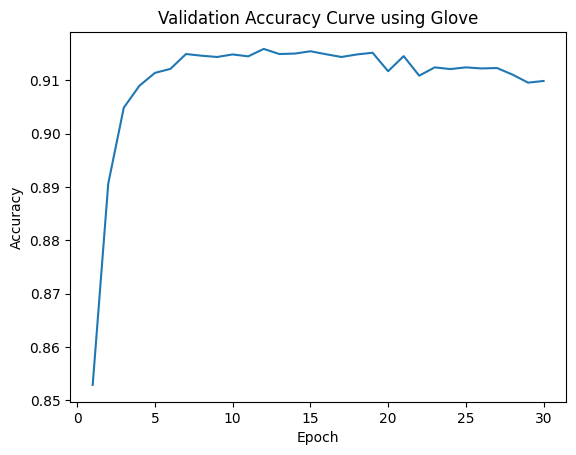

In [ ]:
model_glove = NNPOSTagger_Glove(window_size = 3,
                    vocab_size = len(vocab_words),
                     embedding_dim = 300,
                     hidden_dim = 128,
                     output_dim = len(vocab_ud),
                     nonlinearity = nn.Tanh(),
                     use_glove = True,
                     freeze_glove = False).to(device)

EPOCHS = 30 # epoch
optimizer = torch.optim.Adam(model_glove.parameters(), lr=1e-4)

accuracies_glove=[]
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train_an_epoch(train_dataloader, optimizer, model_glove)
    accuracy = get_accuracy(valid_dataloader, model_glove)
    accuracies_glove.append(accuracy)
    time_taken = time.time() - epoch_start_time

plt.plot(range(1, EPOCHS+1), accuracies_glove)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Validation Accuracy Curve using Glove")

Text(0.5, 1.0, 'Validation Accuracy Curve using Glove (freezed)')

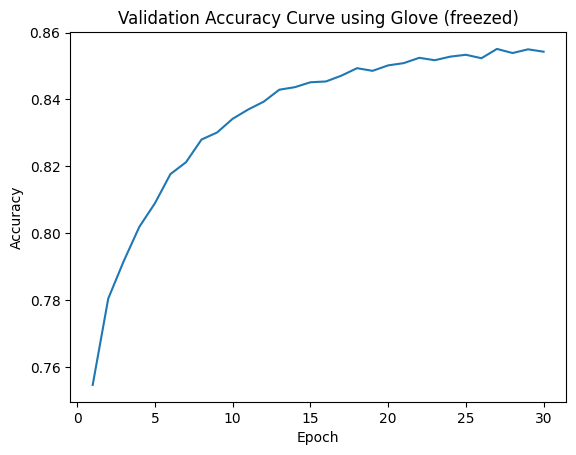

In [ ]:
model_glove_freez = NNPOSTagger_Glove(window_size = 3,
                    vocab_size = len(vocab_words),
                     embedding_dim = 300,
                     hidden_dim = 128,
                     output_dim = len(vocab_ud),
                     nonlinearity = nn.Tanh(),
                     use_glove = True,
                     freeze_glove = True).to(device)

EPOCHS = 30 # epoch
optimizer = torch.optim.Adam(model_glove_freez.parameters(), lr=1e-4)

accuracies_glove_freez=[]
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train_an_epoch(train_dataloader, optimizer, model_glove_freez)
    accuracy = get_accuracy(valid_dataloader, model_glove_freez)
    accuracies_glove_freez.append(accuracy)
    time_taken = time.time() - epoch_start_time

plt.plot(range(1, EPOCHS+1), accuracies_glove_freez)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Validation Accuracy Curve using Glove (freezed)")

### Extending the model

**Task 8** [30]: Try three different ways of your choosing to improve the performance of the model. You may want to vary w, or add additional layers to the network, or increase the size of the hidden vectors $h$, or try with different activation functions. Report on the results you get. Do you think your POS tagger is comparable to a human tagger?

This is an open-ended task.  On it you should spend at least half the time as you spend in total on the previous tasks.  

Method 1: Change the Window Size

Text(0.5, 1.0, 'Validation Accuracy Curve for Window Size 5')

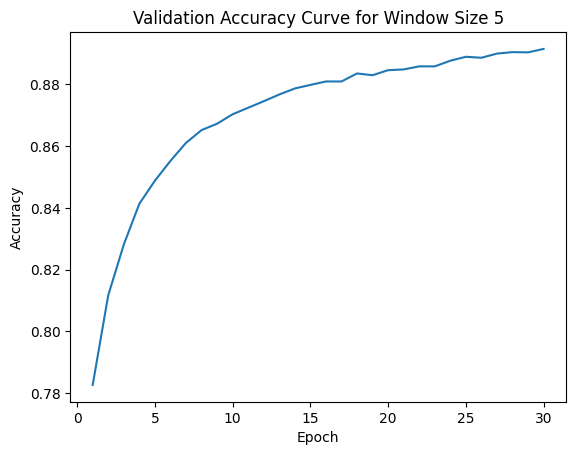

In [ ]:
train_data_5 = list(preprocess_data_seq(train_0, 2))
valid_data_5 = list(preprocess_data_seq(valid_0, 2))
test_data_5 = list(preprocess_data_seq(test_0, 2))

train_dataloader_5 = DataLoader(train_data_5, batch_size=BATCH_SIZE,
                              shuffle=True,
                              collate_fn=collate_fn)
valid_dataloader_5 = DataLoader(valid_data_5, batch_size=BATCH_SIZE,
                              shuffle=False,
                              collate_fn=collate_fn)
test_dataloader_5 = DataLoader(test_data_5, batch_size=BATCH_SIZE,
                             shuffle=False,
                             collate_fn=collate_fn)

model_ws_5 = NNPOSTagger_Glove(window_size=5,
                    vocab_size=len(vocab_words),
                    embedding_dim=300,
                    hidden_dim=128,
                    output_dim=len(vocab_ud),
                    nonlinearity=nn.Tanh(),
                    use_glove=False,
                    freeze_glove=False).to(device)

%matplotlib inline

EPOCHS = 30 # epoch
optimizer = torch.optim.Adam(model_ws_5.parameters(), lr=1e-4)

accuracies_ws_5=[]
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train_an_epoch(train_dataloader_5, optimizer, model_ws_5)
    accuracy = get_accuracy(valid_dataloader_5, model_ws_5)
    accuracies_ws_5.append(accuracy)
    time_taken = time.time() - epoch_start_time

plt.plot(range(1, EPOCHS+1), accuracies_ws_5)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Validation Accuracy Curve for Window Size 5")

Text(0.5, 1.0, 'Validation Accuracy Curve for Window Size 7')

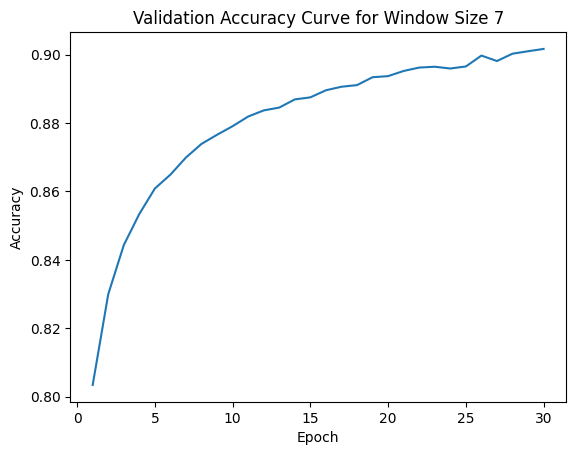

In [ ]:
train_data_7 = list(preprocess_data_seq(train_0, 3))
valid_data_7 = list(preprocess_data_seq(valid_0, 3))
test_data_7 = list(preprocess_data_seq(test_0, 3))

train_dataloader_7 = DataLoader(train_data_7, batch_size=BATCH_SIZE,
                              shuffle=True,
                              collate_fn=collate_fn)
valid_dataloader_7 = DataLoader(valid_data_7, batch_size=BATCH_SIZE,
                              shuffle=False,
                              collate_fn=collate_fn)
test_dataloader_7 = DataLoader(test_data_7, batch_size=BATCH_SIZE,
                             shuffle=False,
                             collate_fn=collate_fn)

model_ws_7 = NNPOSTagger_Glove(window_size=7,
                    vocab_size=len(vocab_words),
                    embedding_dim=300,
                    hidden_dim=128,
                    output_dim=len(vocab_ud),
                    nonlinearity=nn.Tanh(),
                    use_glove=False,
                    freeze_glove=False).to(device)

%matplotlib inline

EPOCHS = 30 # epoch
optimizer = torch.optim.Adam(model_ws_7.parameters(), lr=1e-4)

accuracies_ws_7=[]
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train_an_epoch(train_dataloader_7, optimizer, model_ws_7)
    accuracy = get_accuracy(valid_dataloader_7, model_ws_7)
    accuracies_ws_7.append(accuracy)
    time_taken = time.time() - epoch_start_time

plt.plot(range(1, EPOCHS+1), accuracies_ws_7)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Validation Accuracy Curve for Window Size 7")

Method 2: Increase the size of the hidden vectors  ℎ

Text(0.5, 1.0, 'Validation Accuracy Curve for Hidden Vector 256')

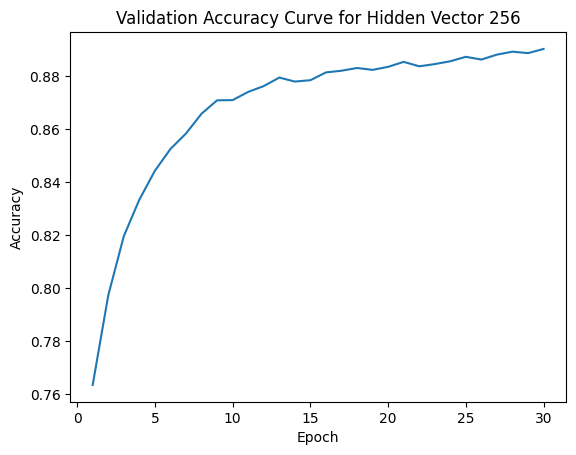

In [ ]:
model_hv_256 = NNPOSTagger_Glove(window_size=3,
                    vocab_size=len(vocab_words),
                    embedding_dim=300,
                    hidden_dim=256,
                    output_dim=len(vocab_ud),
                    nonlinearity=nn.Tanh(),
                    use_glove=False,
                    freeze_glove=False).to(device)

%matplotlib inline

EPOCHS = 30 # epoch
optimizer = torch.optim.Adam(model_hv_256.parameters(), lr=1e-4)

accuracies_hv_256=[]
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train_an_epoch(train_dataloader, optimizer, model_hv_256)
    accuracy = get_accuracy(valid_dataloader, model_hv_256)
    accuracies_hv_256.append(accuracy)
    time_taken = time.time() - epoch_start_time

plt.plot(range(1, EPOCHS+1), accuracies_hv_256)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Validation Accuracy Curve for Hidden Vector 256")

Text(0.5, 1.0, 'Validation Accuracy Curve for Hidden Vector 512')

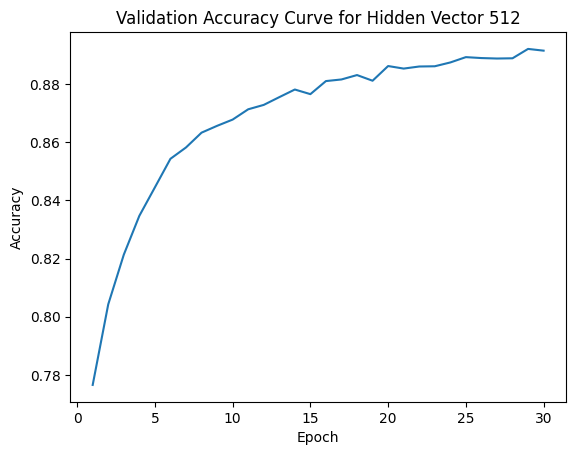

In [ ]:
model_hv_512 = NNPOSTagger_Glove(window_size=3,
                    vocab_size=len(vocab_words),
                    embedding_dim=300,
                    hidden_dim=512,
                    output_dim=len(vocab_ud),
                    nonlinearity=nn.Tanh(),
                    use_glove=False,
                    freeze_glove=False).to(device)

%matplotlib inline

EPOCHS = 30 # epoch
optimizer = torch.optim.Adam(model_hv_512.parameters(), lr=1e-4)

accuracies_hv_512=[]
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train_an_epoch(train_dataloader, optimizer, model_hv_512)
    accuracy = get_accuracy(valid_dataloader, model_hv_512)
    accuracies_hv_512.append(accuracy)
    time_taken = time.time() - epoch_start_time

plt.plot(range(1, EPOCHS+1), accuracies_hv_512)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Validation Accuracy Curve for Hidden Vector 512")

Method 3: Add Additional Layer

In [ ]:
class NNPOSTagger_Glove_Layer3(nn.Module):
    def __init__(self, window_size, vocab_size, embedding_dim,
                 hidden_dim, output_dim, nonlinearity,
                 use_glove=False,
                 freeze_glove=False):
        super(NNPOSTagger_Glove_Layer3, self).__init__()

        # Check if GloVe vectors are to be used
        if use_glove:
            # glove_vectors is a pre-loaded tensor of GloVe embeddings
            self.embedding = nn.Embedding.from_pretrained(glove_vectors, freeze=freeze_glove)
        else:
            # Define a trainable embedding layer if GloVe is not used
            self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(window_size * embedding_dim, hidden_dim)
        self.nonlinearity = nonlinearity

        # Additional linear layers
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, word_idxs_batch):
        embeddings = self.embedding(word_idxs_batch)
        concatenated = embeddings.view(embeddings.shape[0], -1)
        hidden = self.linear1(concatenated)
        activation_output = self.nonlinearity(hidden)

        hidden2 = self.linear2(activation_output)
        activation_output2 = self.nonlinearity(hidden2)
        output = self.linear3(activation_output2)

        log_softmax_output = F.log_softmax(output, dim=1)
        return log_softmax_output

Text(0.5, 1.0, 'Validation Accuracy Curve for Additional Layer')

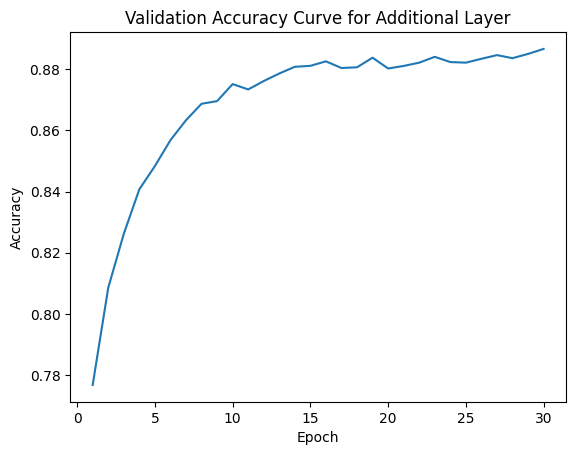

In [ ]:
model_layer_3 = NNPOSTagger_Glove_Layer3(window_size=3,
                    vocab_size=len(vocab_words),
                    embedding_dim=300,
                    hidden_dim=128,
                    output_dim=len(vocab_ud),
                    nonlinearity=nn.Tanh(),
                    use_glove=False,
                    freeze_glove=False).to(device)

%matplotlib inline

EPOCHS = 30 # epoch
optimizer = torch.optim.Adam(model_layer_3.parameters(), lr=1e-4)

accuracies_layer_3=[]
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train_an_epoch(train_dataloader, optimizer, model_layer_3)
    accuracy = get_accuracy(valid_dataloader, model_layer_3)
    accuracies_layer_3.append(accuracy)
    time_taken = time.time() - epoch_start_time

plt.plot(range(1, EPOCHS+1), accuracies_layer_3)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Validation Accuracy Curve for Additional Layer")

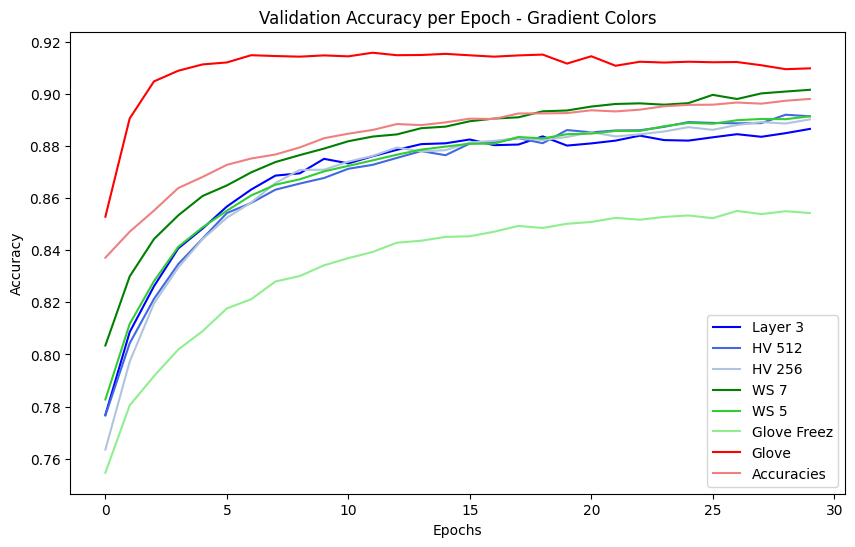

In [ ]:
# Adjusting the plot with more gradient-like colors
plt.figure(figsize=(10, 6))

# Defining a set of gradient colors
colors = ['blue', 'royalblue', 'lightsteelblue', 'green', 'limegreen', 'lightgreen',
          'red', 'lightcoral', 'salmon']

# Plotting each accuracy list with a gradient color
plt.plot(accuracies_layer_3, label='Layer 3', color=colors[0])
plt.plot(accuracies_hv_512, label='HV 512', color=colors[1])
plt.plot(accuracies_hv_256, label='HV 256', color=colors[2])
plt.plot(accuracies_ws_7, label='WS 7', color=colors[3])
plt.plot(accuracies_ws_5, label='WS 5', color=colors[4])
plt.plot(accuracies_glove_freez, label='Glove Freez', color=colors[5])
plt.plot(accuracies_glove, label='Glove', color=colors[6])
plt.plot(accuracies, label='Accuracies', color=colors[7])

plt.title('Validation Accuracy per Epoch - Gradient Colors')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()